**Complete Modeling for Subgroup 3 - Performed by Aditya Kumaran**

I pledge my honor that I have abided by the Stevens Honor System.

In [190]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.ensemble import ExtraTreesClassifier


We have 2163 samples, and only 59 of them are bankrupt. Therefore, this subgroup has very imbalanced data.

In [191]:
#Loading the data

data = pd.read_csv('subgroub3.csv')

print(data['cluster'].value_counts())
print(data['Bankrupt?'].value_counts())

data.shape

cluster
3    2163
Name: count, dtype: int64
Bankrupt?
0    2104
1      59
Name: count, dtype: int64


(2163, 98)

In [192]:
X = data.drop(columns=['Index','cluster','Bankrupt?'])
y = data['Bankrupt?']

**Data Preprocessing**

*We are going to drop features with low importance, and high correlations*

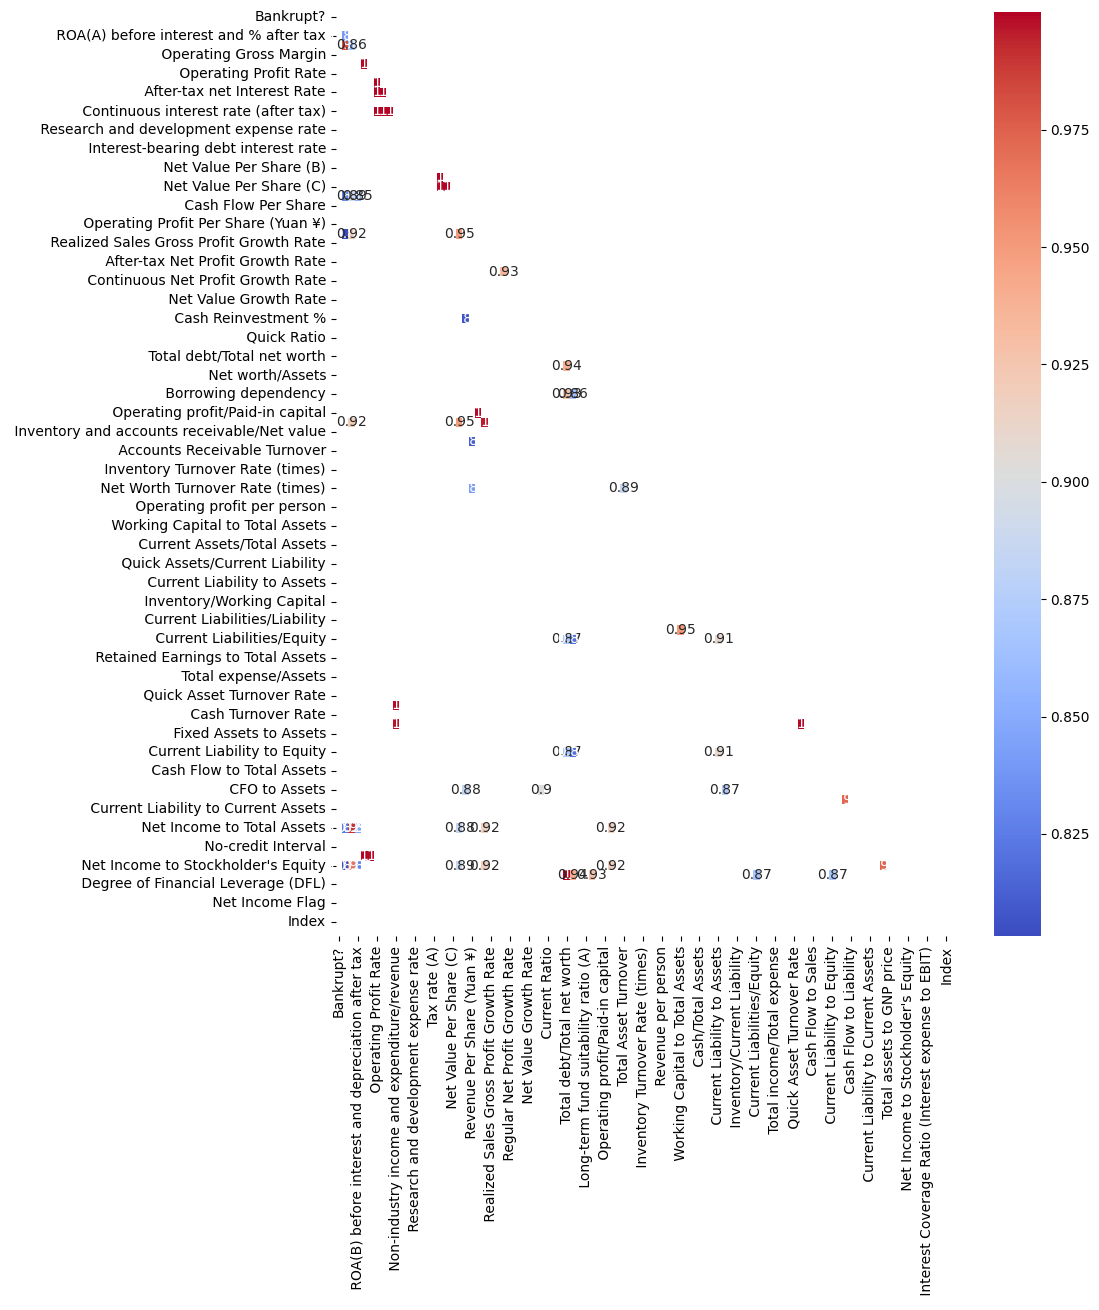

In [193]:
#Correlation Matrix showing correlations > .80

corr_matrix = data.corr()

threshold = 0.8
strong_corr = corr_matrix[(corr_matrix >= threshold) & (corr_matrix < 1.0)]

plt.figure(figsize = (10,12))
mask = np.triu(np.ones_like(strong_corr, dtype=bool))
sns.heatmap(strong_corr, mask=mask, cmap = 'coolwarm', annot = True)
plt.show()

In [194]:
# Compute correlation matrix
corr_matrix = data.corr().abs()

# Keep only upper triangle to avoid duplicate pairs (and self-correlation)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation above threshold
threshold = 0.8
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > threshold]

# Sort by correlation (descending)
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

high_corr_pairs

#saving pairs to colab for easier viewing
high_corr_pairs.to_csv('/content/high_corr_pairs.csv', index=False)


In [195]:
#Using ExtraTreesClassifier to see feature importances
et = ExtraTreesClassifier(n_estimators=100, random_state = 42)
et.fit(X, y)
importances = et.feature_importances_

feature_importances = pd.Series(et.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print(feature_importances)

feature_importances.to_csv('/content/feature_importances.csv') #so that it's easier to view

Borrowing dependency                    0.027717
Liability to Equity                     0.020105
No-credit Interval                      0.020075
Interest-bearing debt interest rate     0.019934
Current Liabilities/Equity              0.019760
                                          ...   
Tax rate (A)                            0.006394
Regular Net Profit Growth Rate          0.006052
Long-term fund suitability ratio (A)    0.005495
Liability-Assets Flag                   0.000000
Net Income Flag                         0.000000
Length: 95, dtype: float64


We will now drop all highly correlated features and features with importance > 0.013

In [196]:
extracted_features = feature_importances[feature_importances > 0.013].index.tolist()

reduced_data = X[extracted_features]

print("We have successfully reduced features to ->", reduced_data.shape[1])
print()
print("Here are the features that are kept so far:")
print(reduced_data.columns)

We have successfully reduced features to -> 19

Here are the features that are kept so far:
Index([' Borrowing dependency', ' Liability to Equity', ' No-credit Interval',
       ' Interest-bearing debt interest rate', ' Current Liabilities/Equity',
       ' Allocation rate per person', ' Cash/Current Liability',
       ' Degree of Financial Leverage (DFL)', ' Debt ratio %',
       ' Current Liability to Equity', ' Total debt/Total net worth',
       ' Average Collection Days', ' Total assets to GNP price',
       ' Net worth/Assets', ' Fixed Assets Turnover Frequency',
       ' Quick Asset Turnover Rate', ' Net Income to Stockholder's Equity',
       ' Interest Expense Ratio', ' Equity to Long-term Liability'],
      dtype='object')


In [197]:
#Finally, lets examine the variance among the remaining dataset and remove anything with REALLY low variance if at all
variance_table = reduced_data.var()
variance_table = variance_table.apply(lambda x: f"{x:.6f}")
variance_table = variance_table.sort_values(ascending = True)

print(variance_table)

reduced_data = reduced_data.drop(columns = [" Net Income to Stockholder's Equity"])

print(reduced_data.shape)

Net Income to Stockholder's Equity                        0.000002
Current Liability to Equity                               0.000006
Current Liabilities/Equity                                0.000006
Liability to Equity                                       0.000009
Total debt/Total net worth                                0.000017
Borrowing dependency                                      0.000018
Equity to Long-term Liability                             0.000048
Interest Expense Ratio                                    0.000100
No-credit Interval                                        0.000140
Degree of Financial Leverage (DFL)                        0.000328
Total assets to GNP price                                 0.001212
Debt ratio %                                              0.001592
Net worth/Assets                                          0.001592
Allocation rate per person                                0.002906
Fixed Assets Turnover Frequency        10289609023822475264.00

Our final, total number of features is 18!

In [198]:
#saving the features in a list for pickle later
feature_names = reduced_data.columns.tolist()

print(feature_names)
print(len(feature_names))

[' Borrowing dependency', ' Liability to Equity', ' No-credit Interval', ' Interest-bearing debt interest rate', ' Current Liabilities/Equity', ' Allocation rate per person', ' Cash/Current Liability', ' Degree of Financial Leverage (DFL)', ' Debt ratio %', ' Current Liability to Equity', ' Total debt/Total net worth', ' Average Collection Days', ' Total assets to GNP price', ' Net worth/Assets', ' Fixed Assets Turnover Frequency', ' Quick Asset Turnover Rate', ' Interest Expense Ratio', ' Equity to Long-term Liability']
18


# **Base Models Training + Stacking**

Training the base models and combining them using stacking.

# **Base Models selected (and reasoning)**


**K-Nearest Neighbors (KNN)**

Strength: Captures local structure, very intuitive.

Weakness: Sensitive to noisy data and irrelevant features.

Contribution to Ensemble: Provides local voting perspective, which differs from tree-based or kernel methods.

**Random Forest**

Strength: Handles high-dimensional data well, robust to noise, feature importance is useful.

Weakness: Can be biased if features are highly correlated.

Contribution to Ensemble: Captures complex interactions and feature importance, often performs well out-of-the-box.

**Support Vector Machine with RBF Kernel (SVM-RBF)**

Strength: Great for high-dimensional, non-linear decision boundaries.

Weakness: Computationally expensive for large datasets, sensitive to hyperparameters.

Contribution to Ensemble: Adds a smooth, margin-maximizing classifier that complements the greedy splits of trees and the instance-based nature of KNN.

In [199]:
#scaling the data

scaler = StandardScaler()
X_scaled_data = scaler.fit_transform(reduced_data)

In [200]:
#applying smote
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_scaled_data, y)

print("Shape of data after SMOTE: ", X_train.shape)
print("Bankrupt Counts: ", y_train.value_counts())

Shape of data after SMOTE:  (4208, 18)
Bankrupt Counts:  Bankrupt?
0    2104
1    2104
Name: count, dtype: int64


In [201]:
#Creating the stacking model

base_learners = [
    ('RF', RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = None)),
    ('KNN', KNeighborsClassifier(n_neighbors = 3)),
    ('SVM-RBF', svm.SVC(kernel='rbf', probability=True))
]

meta_learner = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,  # cross-validation on base learner predictions
    passthrough=True
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_scaled_data)

confusion_mat = confusion_matrix(y, y_pred)

TN, FP, FN, TP = confusion_mat.ravel()
accuracy = TP / (TP + FN)

print("Stacking Matrix Accuracy: ", accuracy)
print("Stacking Matrix Confusion Matrix: ")
print(confusion_mat)
print()
print("Stacking, TP = ", TP, ", FN = ", FN, ", acc: ", accuracy)



Stacking Matrix Accuracy:  1.0
Stacking Matrix Confusion Matrix: 
[[2104    0]
 [   0   59]]

Stacking, TP =  59 , FN =  0 , acc:  1.0


In [202]:
#Printing out Statistics for Base Models

base_models = dict(base_learners)

for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_scaled_data)

    matrix = confusion_matrix(y, y_pred)

    TN, FP, FN, TP = matrix.ravel()
    accuracy = TP / (TP + FN)

    print(f"{name} Matrix Accuracy: ", accuracy)
    print(f"{name} Matrix Confusion Matrix: ")
    print(matrix)
    print()
    print(f" {name}, TP = {TP}, FN = {FN}, acc: {accuracy:.4f},")
    print()


RF Matrix Accuracy:  1.0
RF Matrix Confusion Matrix: 
[[2104    0]
 [   0   59]]

 RF, TP = 59, FN = 0, acc: 1.0000,

KNN Matrix Accuracy:  1.0
KNN Matrix Confusion Matrix: 
[[1999  105]
 [   0   59]]

 KNN, TP = 59, FN = 0, acc: 1.0000,

SVM-RBF Matrix Accuracy:  0.8305084745762712
SVM-RBF Matrix Confusion Matrix: 
[[1852  252]
 [  10   49]]

 SVM-RBF, TP = 49, FN = 10, acc: 0.8305,



In [203]:
#Saving Everything
joblib.dump(stacking_clf, 'stacking_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_names, 'feature_names.pkl')

print("Stacking model, scaler, and feature names saved!")

Stacking model, scaler, and feature names saved!
